## Machine learining con Python i Scikit-learn

Python és un del llenguatges de programació que domina dins l'àmbit de machine learning. Scikit-learn és una llibreria de codi obert que unifica sota un unic marc els principals algoritmes i funcions, facilitant les etapes de preprocessat, entrenament, optimització i validació dels models. 

Llibreries utilitzades:

In [7]:
# Tractament de dades
import numpy as np
import pandas as pd

# Gràfics

import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Preprocessat i modelat

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



## Dades

In [8]:
#Importem el dataset i el preparem. El dataset conté els ECNumbers de 5221 reaccions químiques a més de 6 variables adicionals.
input="data/dataset.csv"

df = pd.read_csv(input, sep=",")
eliminar=["SabioReactionID","Reaction"]
df = df.drop(eliminar, axis=1) #eliminem les columnes que no ens aporten informació per a fer l'estudi.
df = df.dropna()

def modificar_valor(valor):
    numeros = valor.split('.')  # Separem els nombres pel punt (".")
    primer_numero = int(numeros[0])  # obtenim el primer nombre
    return str(primer_numero)  # utilitzem el primer número com a string

# Aplicar la función a la columna 'ECNumber' utilizando el método 'apply'
df['ECNumber'] = df['ECNumber'].apply(modificar_valor)


df.to_csv("data/datasetEC.csv", index=False)

L'objectiu és obtenir un model capaç de predir l'ECNumber de la reacció.

## Anàlisis exploratori

Abans d'entrenar un model predictiu, és molt important realitzar una exploració descriptiva del conjunt de dades. Aquest procés permet entendre millor la informació que conté cada variable, així com detectar possibles errors. 

In [9]:
input="data/datasetEC.csv"
df = pd.read_csv(input, sep=",")
df.head(4)

,ECNumber,MW_R,logP_R,TPSA_R,Rings Count_R,Aromatic Rings_R,Heavy atoms cout_R,Alifatic Rings_R,CSP3_R,BalabanJ_R,...,TPSA_P,Rings Count_P,Aromatic Rings_P,Heavy atoms cout_P,Alifatic Rings_P,CSP3_P,BalabanJ_P,RotatableBonds_P,H-bond donor_P,H-bond acceptor_P
0,5,260.029719,-3.1044,156.91,1.0,1.0,16.0,1.0,1.000000,2.572326,...,156.91,1.0,1.0,16.0,1.0,1.000000,2.613201,4.0,6.0,7.0
1,2,767.025464,-4.7318,436.04,4.0,2.0,47.0,2.0,1.500000,4.302611,...,436.04,4.0,2.0,47.0,2.0,1.500000,4.422680,12.0,13.0,20.0
2,4,339.996049,-2.9858,203.44,1.0,1.0,20.0,1.0,1.000000,2.674029,...,208.12,0.0,0.0,20.0,0.0,1.333333,7.111276,8.0,6.0,8.0
3,5,169.998025,-1.3445,104.06,0.0,0.0,10.0,0.0,0.666667,3.550749,...,104.06,0.0,0.0,10.0,0.0,0.666667,3.560527,4.0,3.0,4.0


# Tipu dels elements de cada columna

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4931 entries, 0 to 4930
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ECNumber            4931 non-null   int64  
 1   MW_R                4931 non-null   float64
 2   logP_R              4931 non-null   float64
 3   TPSA_R              4931 non-null   float64
 4   Rings Count_R       4931 non-null   float64
 5   Aromatic Rings_R    4931 non-null   float64
 6   Heavy atoms cout_R  4931 non-null   float64
 7   Alifatic Rings_R    4931 non-null   float64
 8   CSP3_R              4931 non-null   float64
 9   BalabanJ_R          4931 non-null   float64
 10  RotatableBonds_R    4931 non-null   float64
 11  H-bond donor_R      4931 non-null   float64
 12  H-bond acceptor_R   4931 non-null   float64
 13  MW_P                4931 non-null   float64
 14  logP_P              4931 non-null   float64
 15  TPSA_P              4931 non-null   float64
 16  Rings 

Totes les columnes són del tipus adequat, float i int.

# Nombre d'observacions i valos NaN

És basic coneixer el nombre d'observacions disponibles i si totes elles estan completes. Els valors nuls són molt importants, ja que la majoria d'algoritmes no accepten observacions incompletes o bé es veuen molt infuenciats en cas que en tinguin. És per això que el següent pas és identificar si el dataset conté valors Nan.

In [30]:
df.shape

(4931, 25)

In [10]:
df.isna().sum().sort_values()

ECNumber              0
RotatableBonds_P      0
BalabanJ_P            0
CSP3_P                0
Alifatic Rings_P      0
Heavy atoms cout_P    0
Aromatic Rings_P      0
Rings Count_P         0
TPSA_P                0
logP_P                0
MW_P                  0
H-bond donor_P        0
H-bond acceptor_R     0
RotatableBonds_R      0
BalabanJ_R            0
CSP3_R                0
Alifatic Rings_R      0
Heavy atoms cout_R    0
Aromatic Rings_R      0
Rings Count_R         0
TPSA_R                0
logP_R                0
MW_R                  0
H-bond donor_R        0
H-bond acceptor_P     0
dtype: int64

Cap variable conté valors nuls. 

# Variable Resposta

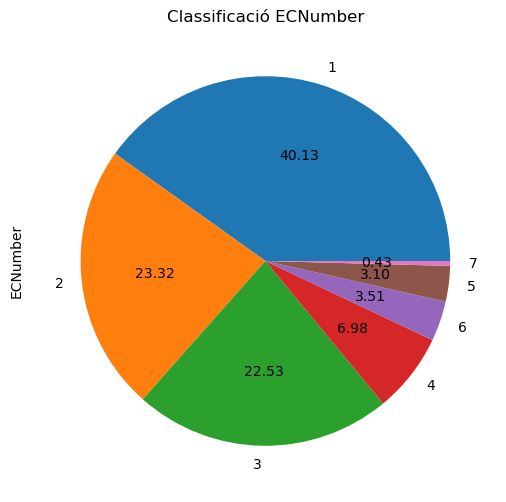

In [11]:
plot = df['ECNumber'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Classificació ECNumber')


## Variable numèriques

In [12]:
# Variables numéricas
df.select_dtypes(include=['float64']).describe()

,MW_R,logP_R,TPSA_R,Rings Count_R,Aromatic Rings_R,Heavy atoms cout_R,Alifatic Rings_R,CSP3_R,BalabanJ_R,RotatableBonds_R,...,TPSA_P,Rings Count_P,Aromatic Rings_P,Heavy atoms cout_P,Alifatic Rings_P,CSP3_P,BalabanJ_P,RotatableBonds_P,H-bond donor_P,H-bond acceptor_P
count,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,...,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000,4931.000000
mean,592.211724,-1.550035,283.489479,3.195498,1.567025,38.629893,1.567025,0.834232,3.534860,10.861894,...,274.509882,3.103833,1.560535,37.418982,1.560535,0.854360,4.118633,10.113567,7.656459,13.240519
std,365.147485,3.195770,165.863698,2.530926,1.532250,23.762839,1.532250,0.429505,1.533356,8.844096,...,159.649520,2.489118,1.535957,22.990916,1.535957,0.458652,1.695864,8.631378,4.574780,8.686946
min,22.989221,-17.258300,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,265.116586,-3.277850,133.765000,1.000000,0.000000,17.000000,0.000000,0.523810,2.354453,4.000000,...,126.670000,1.000000,0.000000,17.000000,0.000000,0.523810,2.851455,3.000000,4.000000,5.000000
50%,584.422946,-1.860600,310.630000,3.000000,1.000000,38.000000,1.000000,0.800000,3.501688,10.000000,...,299.910000,3.000000,1.000000,37.000000,1.000000,0.800000,4.161687,9.000000,8.000000,13.000000
75%,843.672027,0.099200,397.370000,5.000000,2.000000,55.000000,2.000000,1.156190,4.520667,14.000000,...,389.730000,5.000000,2.000000,54.000000,2.000000,1.166667,5.437167,14.000000,11.000000,20.000000
max,4297.940349,17.619200,1660.350000,14.000000,10.000000,299.000000,10.000000,2.000000,10.982608,99.000000,...,1158.520000,14.000000,11.000000,180.000000,11.000000,2.000000,10.967457,80.000000,35.000000,58.000000


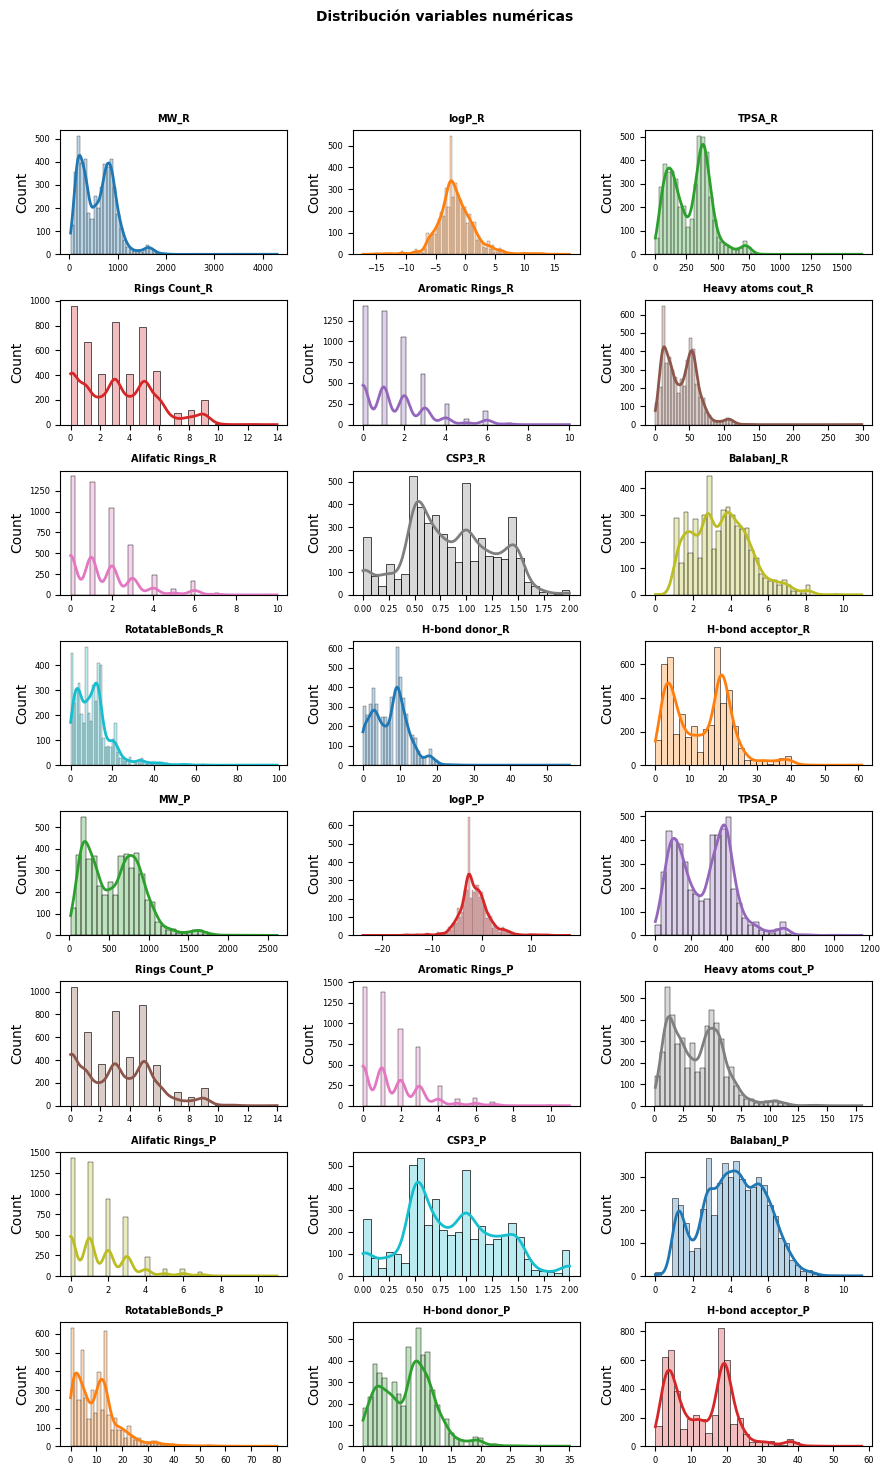

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(9, 15))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64']).columns

for i, column in enumerate(columnas_numeric):
    sns.histplot(
        data     = df,
        x        = column,
        stat     = "count",
        kde      = True,
        color    = (list(plt.rcParams['axes.prop_cycle'])*4)[i]["color"],
        line_kws = {'linewidth': 2},
        alpha    = 0.3,
        ax       = axes[i]
    )
    axes[i].set_title(column, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución variables numéricas', fontsize=10, fontweight="bold")

plt.show()

# Dividim les dades en train i test

Avaluar la capacitat predictiva d'un model consisteix en comprovar com de pròximes són les seves prediccions als vertaders valors de la variable resposta. Per poder quantificar-lo de forma correcte, es necessita disposar d'un conjunt d'observacions, de les que es conegui la variable resposta, però que no hagin participat en el seu ajust. És per això que es divideixen les dades disponibles en un conjunt d'entrenament i un conjunt test. La mida adequada de les particions depèn de la quantitat de dades disponibles, en aquest cas utilitzarem 80% i 20%. La divisió es genera de forma aleatòria-estratificat.

És important verificar que la distribució de la variable resposta és semblant en el conjunt d'entrenament i en el conjunt test. Per assegurar que això és així, la funció train_test_split() de scikit-learn, permet identificar amb l'argument stratify la variable per fer un repartiment equitatiu en ambdós grups. 



In [25]:
input="data/datasetEC.csv"
df = pd.read_csv(input, sep=",")

# Reparto de datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop('ECNumber', axis = 'columns'),
                                        df['ECNumber'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True,
                                        stratify=df['ECNumber'],
                                    )



y_train_counts = y_train.value_counts()
y_train_proportions = y_train.value_counts(normalize=True)

print(y_train_counts)
print(y_train_proportions)

1    1583
2     920
3     889
4     275
6     138
5     122
7      17
Name: ECNumber, dtype: int64
1    0.401369
2    0.233266
3    0.225406
4    0.069726
6    0.034990
5    0.030933
7    0.004310
Name: ECNumber, dtype: float64


In [27]:
y_test_counts = y_test.value_counts()
y_test_proportions = y_test.value_counts(normalize=True)

print(y_test_counts)
print(y_test_proportions)

1    396
2    230
3    222
4     69
6     35
5     31
7      4
Name: ECNumber, dtype: int64
1    0.401216
2    0.233029
3    0.224924
4    0.069909
6    0.035461
5    0.031408
7    0.004053
Name: ECNumber, dtype: float64


Veiem que hi ha la mateixa propurció dels diferents grups de classificació d'ECNumbers en els dos grups, test i train. Per exemple, tenim un 40,03% de ECNumbers del grup 1 i un 23,85% d'ECNumbers corresponents al grup 2. Trobem els mateixos valors tant en el conjunt de test com en el conjunt de train.

## Preprocessat

El preprocessat consta de totes aquelles tranformacions fetes sobre les dades amb l'objectiu de poder ser interpretades per l'algoritme de _machine learning_ de la manera més eficient possible. El preprocessat s'ha de fer amb el conjunt d'entrenament i després aplicar-se en el conjunt de test. Això és important per tal que cap informació procedent de les observacions de test influeixin en l'ajust del model. 

Seguidament utilizem el codi StandardScaler per estandaritzar les varibales numèriques en els conjunts d'entrenament i test. Aquesta estandarització ajuda a garantitzar que les veriables tinguin una escala comparable i estiguin centrades al voltant del zero abans d'entrenar el model. 

In [28]:
# Feature Scaling
scaler = StandardScaler() #es crea l'objecte scaler que s'utilitza per estandaritzar les característiques, ajuda a evitar biaixos
X_train = scaler.fit_transform(X_train) #s'ajusta i transforma les variables numèriques en el conjunt d'entrenament. 
X_test = scaler.transform(X_test)#es transformen les característiques del conjunt test. transform aplica la mateixa transformació que en les dades d'entrenament. Aixó assegura que les variables de test s'estandaritzin de la mateixa manera.


## Creació dels models.

# Random Forest

El model Random Forest està format per un conjunt d'arbres de decisió individuals, cada un entrenat amb una mostra lleugerament diferent de les dades d'entrenament generada mitjançant bootstrapping. La predicció d'una nova observació s'obté agregant les prediccions de tots els arbres individuals que formen el model.

In [18]:
# Fitting Random Forest Classification to the Training set
rf_classifier = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 100) #creem un objecte de la classe RandomForestClassifier
rf_classifier.fit(X_train, y_train)  #entrenem el model utilitzant el conjunt d'entrenament



RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=100)

Realitzem prediccions del conjunt test

In [19]:
y_pred = rf_classifier.predict(X_test)

Determinem la precisió del model

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8905775075987842


En el model Random Forest s'ha obtingut un accuracy del 82.4%. Això significa que el model realitza prediccions correctes en aproximadament un 82,4% dels asos en el conjunt test. 

# Error del test

Seguidament analitzarem el rendiment del model. 

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred)) #mostrem l'informa del model.

              precision    recall  f1-score   support

           1       0.95      0.94      0.94       396
           2       0.87      0.92      0.89       230
           3       0.84      0.93      0.88       222
           4       0.77      0.77      0.77        69
           5       0.94      0.52      0.67        31
           6       0.91      0.60      0.72        35
           7       1.00      0.25      0.40         4

    accuracy                           0.89       987
   macro avg       0.90      0.70      0.75       987
weighted avg       0.89      0.89      0.89       987



L'informe de classificació obtingut proporciona diferents paràmetres per avaluar el rendiment en el conjunt test. 

- Precisió: consisteix en la proporció de casos positius que van ser correctament identificats. Podem veure que en els grups on tenim més quantitat de mostres obtenim millors resultats. En el grup 7 com que tenim molt poques mostres classificades dins l'ECNumber 7 la precisió és 0%. 

- Recall: tambés es coneix com la sensibilitat o taxa de verdaders positius, és la proporció de casos positius reals que van ser correctament identificats. Tenim el mateix problema que en el paràmetre anterior.

- F1-score: es un paràmetre que combina la precisió i el recall. 

- Support: és el número d'instàncies de cada classe en el conjunt test. Veiem que en el grup 7 tenim molt poques mostres per això obtenim resultats dolents en aquest grup.

- Accuracy: és la proporció de prediccions correctes. 

## Visualització dels resultats

Seguidament per tal de visualitzar els resultats obtinguts en el model generarem una martiu de confusió i a continuació la visualitzarem generant un gràfic de mapa de calor. La matriu de confusió és una eina utilitzada en l'avaluació de models de classificació. Proporciona una visió general de com el model classifica les mostres en diferents categories i ajuda a avaluar el rendiment del model.

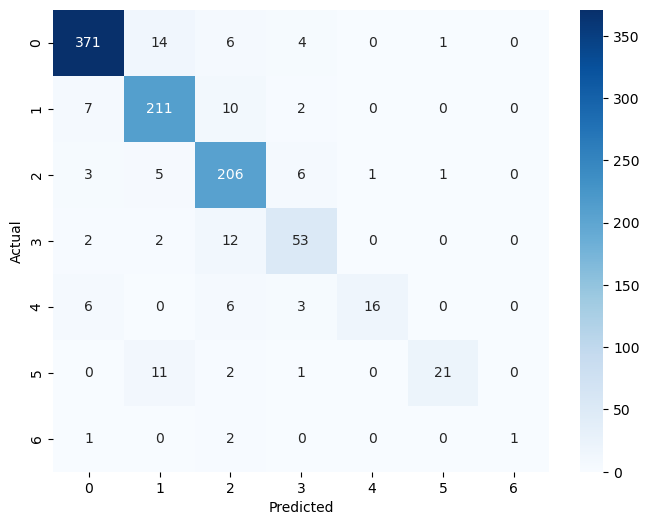

In [22]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



El mapa de calor ens permet visuallitzar de manera ràpida i senzilla els patrons de classificació correctes i incorrectes del model. La concentració de colors més foscos en la diagonal principal indiquen una classificació correcte mentre que els valors fora de la diagonal principal indiquen errors de classificació. Els resultats analitzats anteriorment ara els podem visualitzar en aquest mapa. 

A continuació exportarem i visualitzarem els primers tres arbres de decisió generats pel model RF. 

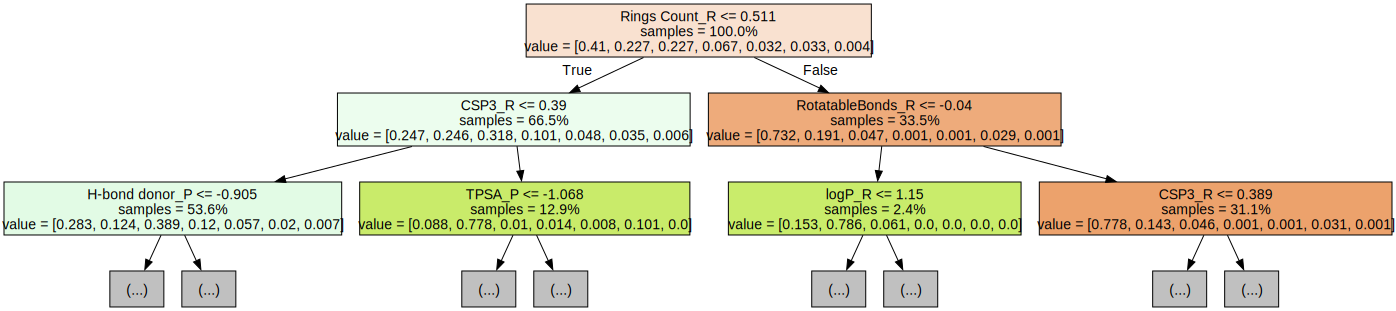

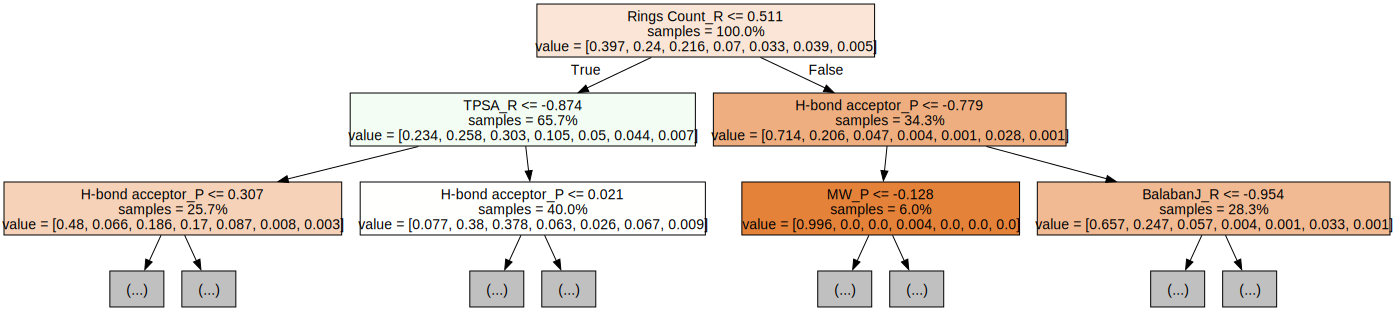

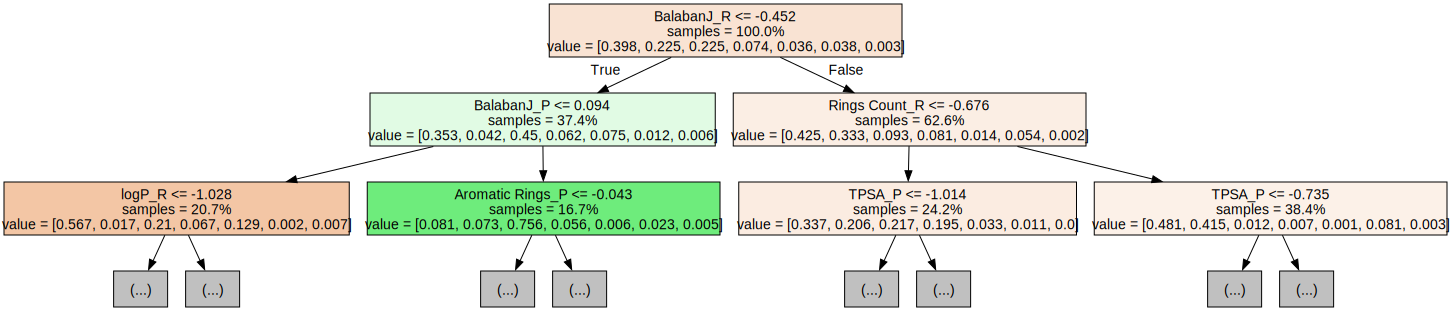

In [44]:
# Export the first three decision trees from the forest
# Convert X_train to a DataFrame
X_train_df = pd.DataFrame(X_train, columns=["MW_R",'logP_R',"TPSA_R", "Rings Count_R", "Aromatic Rings_R", "Heavy atoms cout_R", "Alifatic Rings_R", "CSP3_R", "BalabanJ_R", "RotatableBonds_R", "H-bond donor_R", "H-bond acceptor_R", "MW_P",'logP_P',"TPSA_P", "Rings Count_P", "Aromatic Rings_P", "Heavy atoms cout_P", "Alifatic Rings_P", "CSP3_P", "BalabanJ_P", "RotatableBonds_P", "H-bond donor_P", "H-bond acceptor_P"])

# Export the first three decision trees from the forest
for i in range(3):
    tree = rf_classifier.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


# K-Nearest Neighbor (K-NN)

És un algoritme utilitzat per problemes de classificació i també per regressió. En la classificació, el K.NN assigna una classe a una nova instancia basant-se en les classes dels seus veïns més propers en l'espai de característiques. El seu funcionament és força simple. Donat un conjunt de dades d'entrenament amb característiques i etiquetes, el model emmagatzema todes les instancies en memòria. Quan es presenta una nova instància per classificar o predir, l'algoritme calcula la distància entre la nova instància i totes les instàncies del conjunt d'entrenament. Seguidament, l'algoritme utilitza les etiquetes dels veïns per a classificar la nova instància o predir el seu valor.

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [54]:
k = 3 # Nombre de veïns a considerar
classifier = KNeighborsClassifier(n_neighbors=k)

In [55]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [56]:
y_pred = classifier.predict(X_test)

In [57]:
accuracy = accuracy_score(y_test, y_pred)
print("Precisión:", accuracy)

Precisión: 0.8763931104356636


In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.94      0.94      0.94       396
           2       0.88      0.88      0.88       230
           3       0.82      0.91      0.87       222
           4       0.73      0.75      0.74        69
           5       0.93      0.45      0.61        31
           6       0.81      0.60      0.69        35
           7       0.50      0.25      0.33         4

    accuracy                           0.88       987
   macro avg       0.80      0.68      0.72       987
weighted avg       0.88      0.88      0.87       987



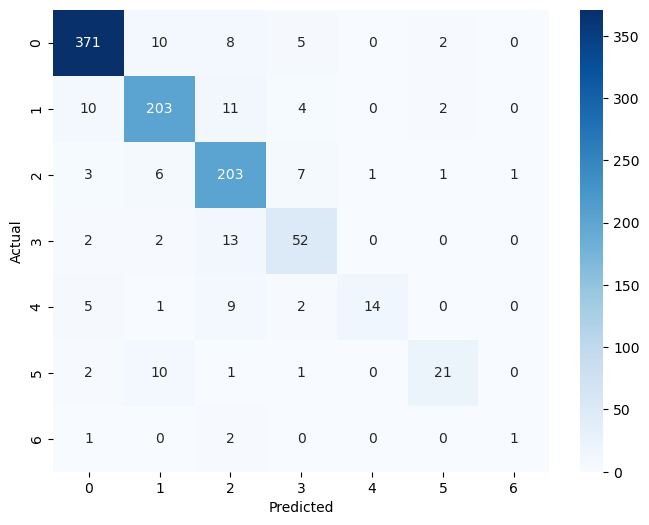

In [59]:
# Obtener la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Gradient Boosting Trees

És un algoritme que combina múltiples arbres de decisió dèbils per a crear un model de predicció més fort. A diferència dels mètodes Random Forest, el GBT contrueix els arbres sequencialment de manera que cada nou arbre s'enfoca en corregir els error comesos pels arbres anteriors. 

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Generem el model Boosting Trees
model = GradientBoostingClassifier()

# Entrenem el model
model.fit(X_train, y_train)

# Realitzem les prediccions en el conjunt test.
y_pred = model.predict(X_test)

# Calculem la precisió del model. 
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.878419452887538


In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.93      0.94       396
           2       0.87      0.89      0.88       230
           3       0.83      0.96      0.89       222
           4       0.70      0.67      0.68        69
           5       0.82      0.45      0.58        31
           6       0.90      0.54      0.68        35
           7       0.50      0.50      0.50         4

    accuracy                           0.88       987
   macro avg       0.80      0.71      0.74       987
weighted avg       0.88      0.88      0.87       987



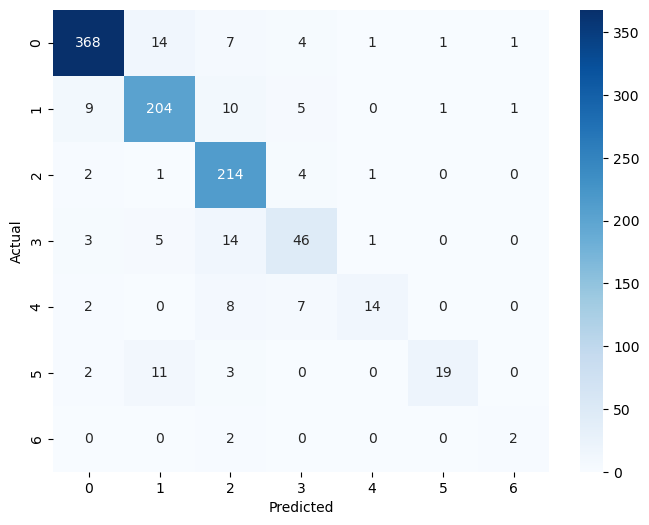

In [62]:
# Obtenim la matriu de confusió.
cm = confusion_matrix(y_test, y_pred)

# Visualitzem la matriu
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## SUPORT VECTOR MACHINE

In [66]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


clf = svm.SVC(kernel='rbf')  # Podem seleccionar diferents kernels com 'linear', 'rbf', 'poly', etc. en aquest cas el que millor defineix el model és Rrbf
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8368794326241135


In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      0.92      0.90       396
           2       0.84      0.85      0.85       230
           3       0.79      0.94      0.86       222
           4       0.76      0.54      0.63        69
           5       0.75      0.29      0.42        31
           6       0.92      0.31      0.47        35
           7       0.00      0.00      0.00         4

    accuracy                           0.84       987
   macro avg       0.70      0.55      0.59       987
weighted avg       0.83      0.84      0.82       987



/opt/anaconda3/envs/tfm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tfm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tfm/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


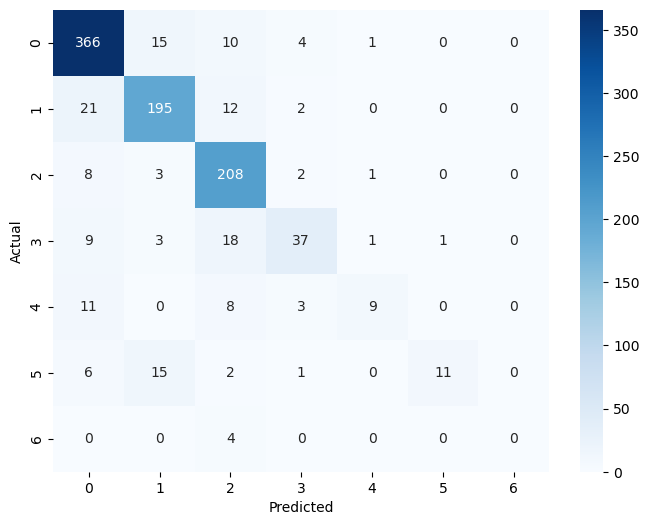

In [68]:
# Obtenim la matriu de confusió 
cm = confusion_matrix(y_test, y_pred)

# Visualitzem la matriu
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt